<br><br>

# DQLab Internal Data Challenge 3

### Adriyan

<br><br>

In [1]:
import mysql.connector
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette="deep", font_scale=1.2)


[**Relational database of UW_std**](https://relational.fit.cvut.cz/dataset/UW-CSE)

![Relational database of UW_std](https://relational.fit.cvut.cz/assets/img/datasets-generated/UW_std.svg)

<br><br>

## 1. Acquiring database `UW_std` from `host="relational.fit.cvut.cz"`

Creating MySQL connection as `my_conn` 

In [2]:
my_conn = mysql.connector.connect(host="relational.fit.cvut.cz",
                                  port=3306,
                                  user="guest",
                                  passwd="relational",
                                  database="UW_std",
                                  use_pure=True)

Creating a SQL query `my_query` for querying the database `UW_std`

In [3]:
my_query = """
            SELECT p.*, a.p_id_dummy, t.course_id, c.courseLevel
            FROM person AS p
            LEFT OUTER JOIN advisedBy AS a
            ON p.p_id = a.p_id
            LEFT OUTER JOIN taughtBy AS t
            ON p.p_id = t.p_id
            LEFT OUTER JOIN course AS c
            ON t.course_id = c.course_id
           """

Read the database which stored into `pandas.DataFrame` as `my_df` from the query `my_query` and the connection `my_conn`

In [4]:
my_df = pd.read_sql_query(my_query, my_conn)

Store the acquired database `my_df` into a CSV file: `uw_cse.csv`  

In [5]:
my_df.to_csv("uw_cse.csv", index=False)

Close the connection `my_conn` and delete `my_df`

In [6]:
my_conn.close()
del(my_df)

<br><br>

## 2. Analyze the data set which already dumped into CSV file

Read the csv file `uw_cse.csv`

In [7]:
my_df = pd.read_csv("uw_cse.csv")
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 9 columns):
p_id              425 non-null int64
professor         425 non-null int64
student           425 non-null int64
hasPosition       425 non-null object
inPhase           425 non-null object
yearsInProgram    425 non-null object
p_id_dummy        113 non-null float64
course_id         189 non-null float64
courseLevel       189 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 30.0+ KB


Changing few columns

In [8]:
my_df = (my_df.astype({"p_id": np.uint16,
                      "professor": np.uint8,
                      "student": np.uint8,
                      "p_id_dummy": pd.Int32Dtype(),
                      "course_id": pd.Int32Dtype()})
        )
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 9 columns):
p_id              425 non-null uint16
professor         425 non-null uint8
student           425 non-null uint8
hasPosition       425 non-null object
inPhase           425 non-null object
yearsInProgram    425 non-null object
p_id_dummy        113 non-null Int32
course_id         189 non-null Int32
courseLevel       189 non-null object
dtypes: Int32(2), object(4), uint16(1), uint8(2)
memory usage: 19.2+ KB


In [9]:
my_df.head(10)

,p_id,professor,student,hasPosition,inPhase,yearsInProgram,p_id_dummy,course_id,courseLevel
0,3,0,1,0,0,0,NaN,NaN,NaN
1,4,0,1,0,0,0,NaN,NaN,NaN
2,5,1,0,Faculty,0,0,NaN,19,Level_500
3,5,1,0,Faculty,0,0,NaN,51,Level_400
4,5,1,0,Faculty,0,0,NaN,71,Level_500
5,6,0,1,0,Post_Quals,Year_2,29,NaN,NaN
6,6,0,1,0,Post_Quals,Year_2,165,NaN,NaN
7,7,1,0,Faculty_adj,0,0,NaN,NaN,NaN
8,9,0,1,0,Post_Generals,Year_5,335,124,Level_300
9,13,0,1,0,Post_Generals,Year_7,240,NaN,NaN


<br>

#### Finding some insight from dataset `my_df`

**a. Students who advised by professors**

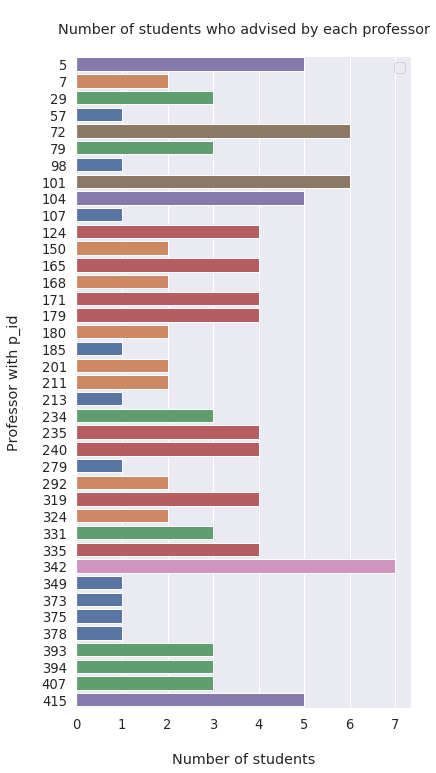

In [10]:
_a_ = (my_df.groupby(by="p_id_dummy", sort=True, as_index=False)
           .agg("count")[["p_id_dummy", "student"]]
      )

fig = plt.figure(figsize=(6, 12))
ax = fig.subplots()
sns.barplot(data=_a_, y="p_id_dummy", x="student", hue="student",
            dodge=False, ax=ax, orient='h')
ax.set_xlabel("\nNumber of students")
ax.set_ylabel("Professor with p_id\n")
ax.legend("")
plt.title("\nNumber of students who advised by each professor\n");


**>>> INSIGHT:**

Here the top six of professors advised students in term of number of students

In [11]:
_a_.rename(columns={"p_id_dummy": "Professor with p_id",
                    "student": "Number of students"}).head(6)


,Professor with p_id,Number of students
0,5,5
1,7,2
2,29,3
3,57,1
4,72,6
5,79,3


<br>

**b. Position of professors who acted as student advisor**

,Position,Number of professor
0,0,1
1,Faculty,32
2,Faculty_adj,4
3,Faculty_aff,1
4,Faculty_eme,1


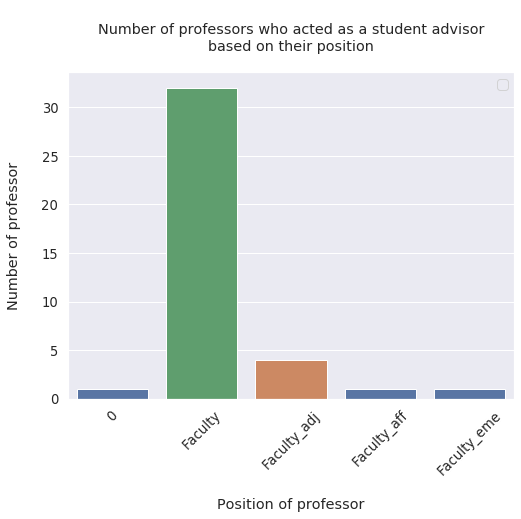

In [12]:
_b_ = (my_df.groupby(by=["hasPosition", "p_id"], as_index=False)
           .agg("min")
           .set_index("p_id")
      )
_b1_ = (_b_.loc[sorted(_a_["p_id_dummy"]), :]
           .reset_index()
           .groupby(by="hasPosition", as_index=False)
           .agg("count")[["hasPosition", "professor"]])

fig = plt.figure(figsize=(8, 6))
ax = fig.subplots()
sns.barplot(data=_b1_, x="hasPosition", y="professor", hue="professor",
            dodge=False, ax=ax)
ax.set_xlabel("\nPosition of professor")
plt.xticks(rotation=45)
ax.set_ylabel("Number of professor\n")
ax.legend("")
plt.title("\nNumber of professors who acted as a student advisor\nbased on their position\n");

display(_b1_.rename(columns={"hasPosition": "Position",
                             "professor": "Number of professor"}))

**>>> INSIGHT:**

Professors which appointed as as *faculty* are the most position who acted as student advisor.

<br>

**c. A combination of a and b**

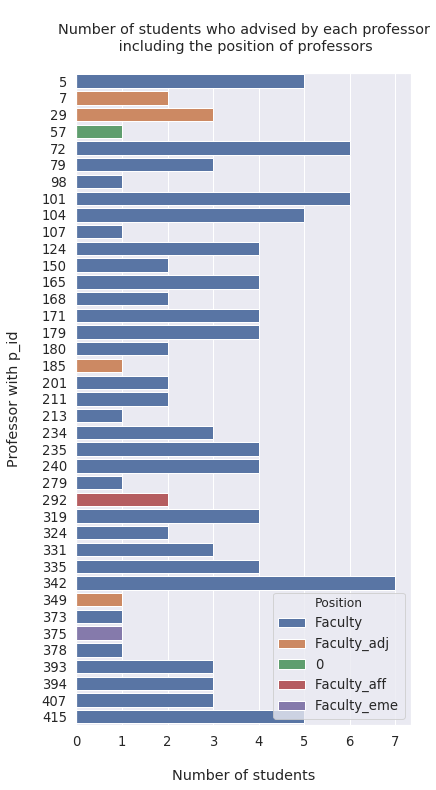

In [13]:
_c_ = (_a_.merge(_b_.loc[sorted(_a_["p_id_dummy"]), "hasPosition"], 
                 how="left", left_on="p_id_dummy", right_on="p_id")
          .rename(columns={"p_id_dummy": "Professor with p_id",
                           "student": "Number of students",
                           "hasPosition": "Position"}))

fig = plt.figure(figsize=(6, 12))
ax = fig.subplots()
sns.barplot(data=_c_, x="Number of students", 
            y="Professor with p_id", hue="Position",
            dodge=False, ax=ax, orient="h")
ax.set_ylabel("Professor with p_id\n")
ax.set_xlabel("\nNumber of students")
plt.title("\nNumber of students who advised by each professor\n including the position of professors\n");


<br>

**d. Course taught by professor**

,courseLevel,hasPosition,professor
0,Level_300,0,12
1,Level_300,Faculty,17
2,Level_300,Faculty_eme,1
3,Level_400,0,12
4,Level_400,Faculty,54
5,Level_400,Faculty_adj,2
6,Level_400,Faculty_aff,1
7,Level_400,Faculty_eme,3
8,Level_500,0,4
9,Level_500,Faculty,80


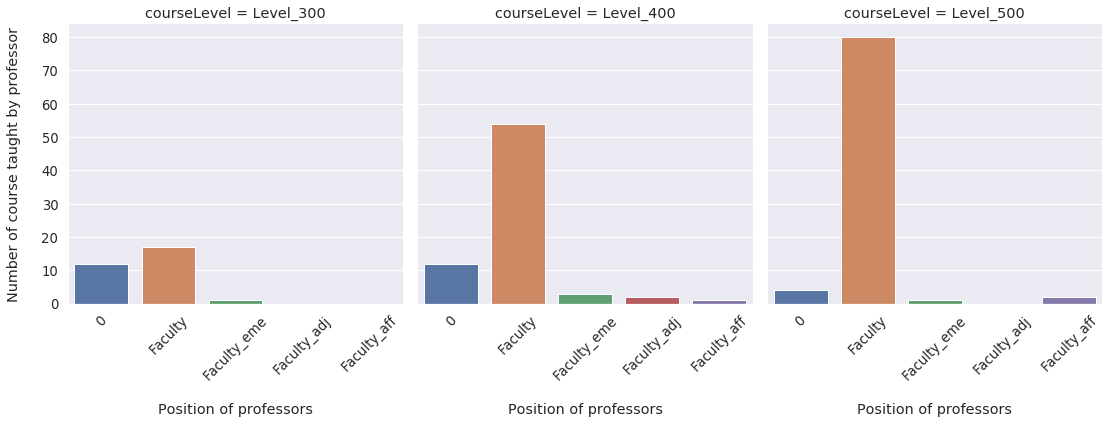

In [32]:
_d_ = (my_df.groupby(by=["courseLevel", "hasPosition"], 
                     as_index=False)
           .agg("count"))

p = sns.catplot(data=_d_, 
                col="courseLevel",
                x="hasPosition",
                y="professor", 
                col_wrap=5,
                hue="hasPosition",
                dodge=False,
                kind="bar")
p.set_axis_labels("\nPosition of professors", "Number of course taught by professor\n")
[plt.setp(item.get_xticklabels(), rotation=45) for item in p.axes];

display(_d_[["courseLevel", "hasPosition", "professor"]]
            .rename({"courseLevel": "Course on", 
                     "hasPosition": "Position", 
                     "professor": "Number of course taught by professor"}))


<br>

**e. Course taken by students**

,courseLevel,inPhase,yearsInProgram,student
0,Level_300,0,27,27
1,Level_300,Post_Generals,3,3
2,Level_400,0,67,67
3,Level_400,Post_Generals,3,3
4,Level_400,Post_Quals,1,1
5,Level_400,Pre_Quals,1,1
6,Level_500,0,86,86
7,Level_500,Pre_Quals,1,1


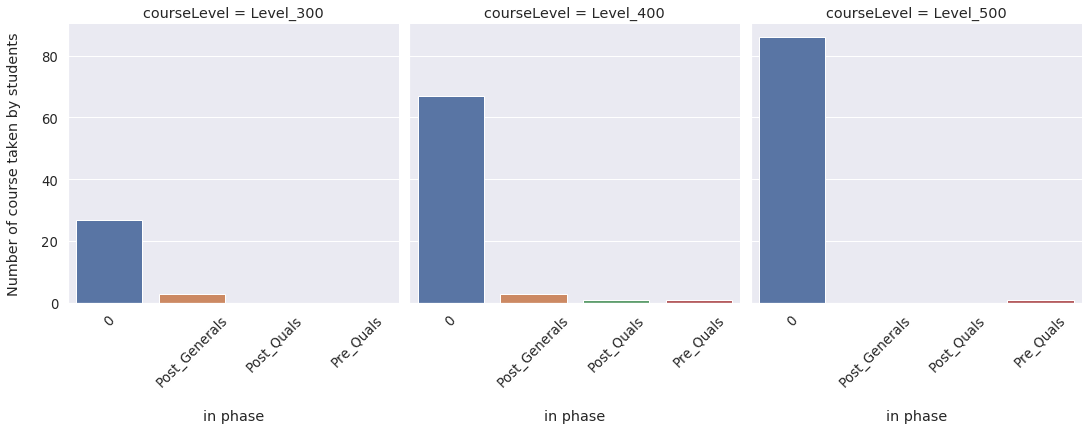

In [27]:
_e_ = (my_df.groupby(by=["courseLevel", "inPhase"], 
                     as_index=False)
           .agg("count"))

p = sns.catplot(data=_e_, 
                col="courseLevel",
                x="inPhase",
                y="student",
                hue="inPhase",
                col_wrap=3,
                dodge=False,
                kind="bar")
p.set_axis_labels("\nin phase", "Number of course taken by students\n")
[plt.setp(item.get_xticklabels(), rotation=45) for item in p.axes];

display(_e_[["courseLevel", "inPhase", "yearsInProgram", "student"]])

,courseLevel,inPhase,yearsInProgram,student
0,Level_300,27,0,27
1,Level_300,1,Year_5,1
2,Level_300,2,Year_6,2
3,Level_400,67,0,67
4,Level_400,1,Year_2,1
5,Level_400,1,Year_3,1
6,Level_400,1,Year_5,1
7,Level_400,2,Year_6,2
8,Level_500,86,0,86
9,Level_500,1,Year_2,1


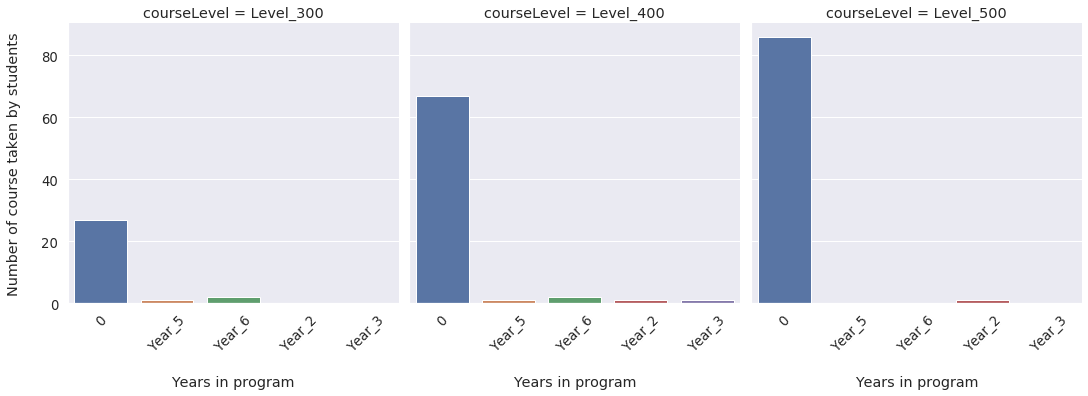

In [31]:
_e2_ = (my_df.groupby(by=["courseLevel", "yearsInProgram"], 
                     as_index=False)
           .agg("count"))

p = sns.catplot(data=_e2_, 
                col="courseLevel",
                x="yearsInProgram",
                y="student",
                hue="yearsInProgram",
                col_wrap=3,
                dodge=False,
                kind="bar")
p.set_axis_labels("\nYears in program", "Number of course taken by students\n")
[plt.setp(item.get_xticklabels(), rotation=45) for item in p.axes];

display(_e2_[["courseLevel", "inPhase", "yearsInProgram", "student"]])